In [1]:
import cv2
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 15)

In [2]:
def prepare_img(img, roi=None, downscale_factor=4, kernel_size=3):
    """
    Prepare image for keypoint matching
    :param img: Image in BGR format
    :param roi: Region of interest to crop image to in format x0, y0, x1, y1
    :param downscale_factor: Factor to downscale image
    :param kernel_size: Size of kernel for blurring
    :return: Grayed, downscaled and blurred image
    """
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[roi[1]:roi[3], roi[0]:roi[2]] if roi is not None else img
    img = cv2.resize(img, (int(img.shape[1] // downscale_factor), int(img.shape[0] // downscale_factor)))
    img = cv2.medianBlur(img, kernel_size)
    
    return img


def get_good_matches(ref_descs, descs, ratio_thresh=0.15):
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matcher = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 5}, {'checks': 50})
    matches = matcher.knnMatch(ref_descs, descs, k=2)
    
    good_matches = []
    for match in matches:
        if len(match) > 1:
            if match[0].distance < ratio_thresh * match[1].distance:
                good_matches.append(match)
    
    return good_matches


def plot_matches(img1, img2, pts1, pts2, matches):
    ref_kps = [cv2.KeyPoint(*pt, 50) for pt in pts1]
    kps = [cv2.KeyPoint(*pt, 50) for pt in pts2]
    
    vis = cv2.drawMatchesKnn(img1, ref_kps, img2, kps, matches, None, flags=2)
    plt.imshow(vis)
    plt.show()


def get_matching_points(img1, img2, roi1=None, roi2=None, downscale_factor=4, kernel_size=3, ratio_thresh=0.15, plot=False):
    """
    Using points and descriptors retrieved by a keypoint matcher (here: AKAZE) generate bounding boxes on a new image
    For robustness and accuracy, for each labeled object only nearby keypoints are considered and outliers are removed
    :param img1: Reference image
    :param img2: New image to compare
    :param roi1: Region of interest to crop image to in format x0, y0, x1, y1
    :param roi2: Region of interest to crop image to in format x0, y0, x1, y1
    :param downscale_factor: Scaling factor to resize image for better feature extraction
    :param kernel_size: Size of kernel for blurring
    :param ratio_thresh: Threshold to filter out bad matches [0, 1] (the higher the more matches will be considered)
    :param plot: Whether to plot the matched pairs of keypoints
    :return: Average shift in keypoints
    """
    
    # detector = cv2.AKAZE_create()
    detector = cv2.xfeatures2d.SIFT_create()
    
    # Get keypoints and descriptor for compared image
    kpss, descss = [], []
    for img, roi in zip([img1, img2], [roi1, roi2]):
        img_prepd = prepare_img(img, roi=roi, downscale_factor=downscale_factor, kernel_size=kernel_size)
        kps, descs = detector.detectAndCompute(img_prepd, None)
        
        kpss.append(kps)
        descss.append(descs)
    
    # Get actual points for original image by transforming back the keypoints
    pss = [np.array([kp.pt for kp in kps]) * downscale_factor + (roi[:2] if roi is not None else (0, 0)) for kps, roi in zip(kpss, [roi1, roi2])]
    
    # Filter keypoints and descriptors of current image based on matches with reference image
    tries = 0
    good_matches = get_good_matches(*descss, ratio_thresh=ratio_thresh)
    while len(good_matches) == 0 and tries < 3:  # Succesively increaser ratio_thresh to get more matches
        good_matches = get_good_matches(*descss, ratio_thresh=min((tries + 2) * ratio_thresh, 0.99))
        tries += 1
    
    matched_pts1 = pss[0][[match[0].queryIdx for match in good_matches]]
    matched_pts2 = pss[1][[match[0].trainIdx for match in good_matches]]
    
    if plot:
        plot_matches(img1, img2, *pss, good_matches)
    
    return pss[0], pss[1], good_matches, matched_pts1, matched_pts2


def filter_matches(matched_pts1, matched_pts2):
    dists = [cosine(matched_pt1, matched_pt2) for matched_pt1, matched_pt2 in zip(matched_pts1, matched_pts2)]
    q75, q25 = np.percentile(dists, [75, 25])
    iqr = q75 - q25
    mask = (dists > q25 - 1.5 * iqr) & (dists < q75 + 1.5 * iqr)
    
    return matched_pts1[mask], matched_pts2[mask]

In [3]:
img_paths = [f"../assets/test_images/{i}Hill.jpg" for i in range(1, 4)]

In [4]:
img1, img2, img3 = [cv2.imread(path) for path in img_paths]

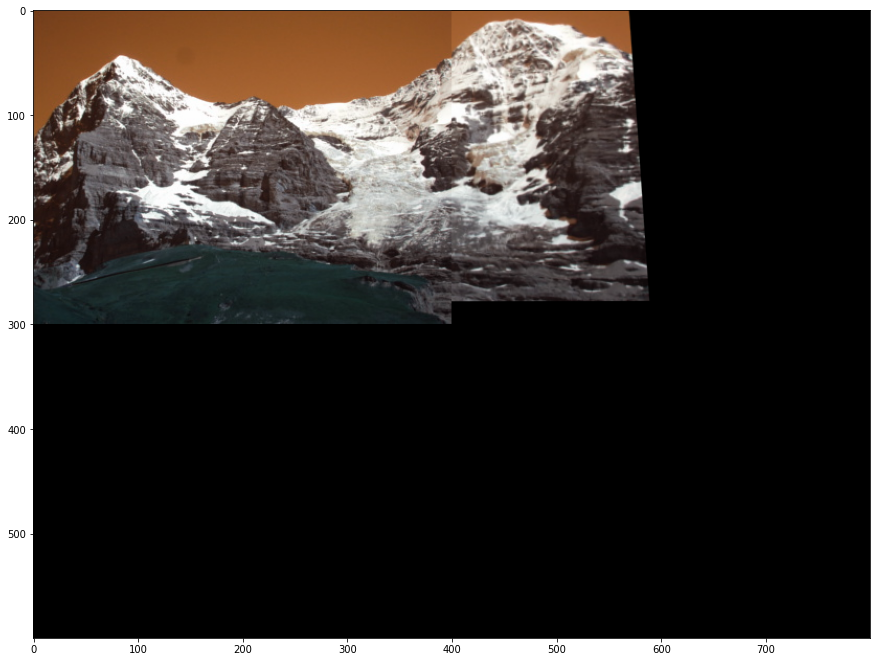

In [9]:
pts1, pts2, good_matches, matched_pts1, matched_pts2 = get_matching_points(img1, img2, ratio_thresh=0.7)

homography, _ = cv2.findHomography(matched_pts2, matched_pts1, cv2.RANSAC, 4)

stitched = cv2.warpPerspective(img2, homography, (img1.shape[1] * 2, img1.shape[0] * 2))
stitched[:img1.shape[0], :img1.shape[1]] = img1
plt.imshow(stitched)

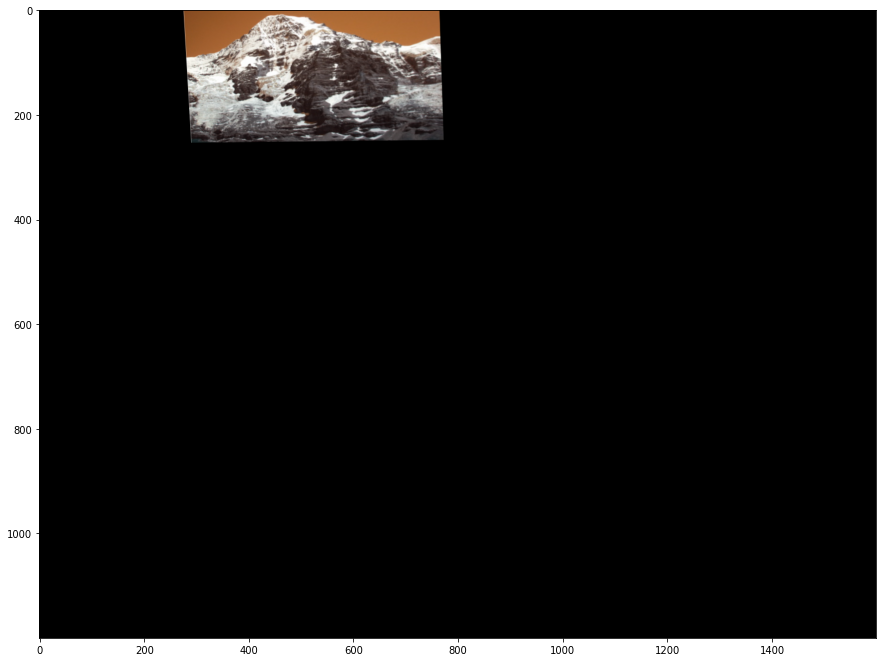

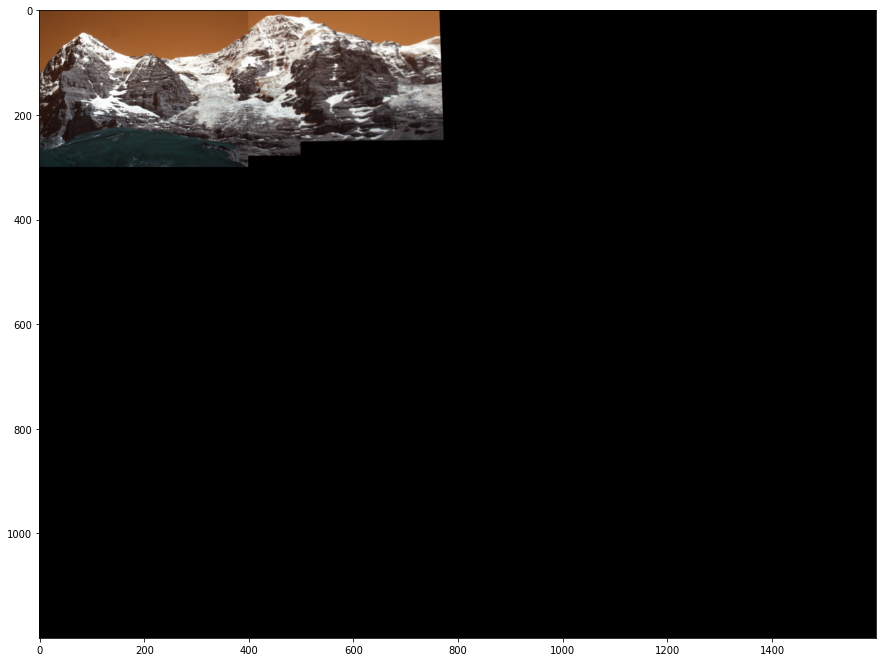

In [16]:
pts1, pts2, good_matches, matched_pts1, matched_pts2 = get_matching_points(stitched, img3, ratio_thresh=0.7)

homography, _ = cv2.findHomography(matched_pts2, matched_pts1, cv2.RANSAC, 4)

stitched2 = cv2.warpPerspective(img3, homography, (stitched.shape[1] * 2, stitched.shape[0] * 2))
plt.imshow(stitched2)
plt.show()
stitched2[:300, :500] = stitched[:300, :500]
plt.imshow(stitched2)
plt.show()

## Trying to use homography between original images

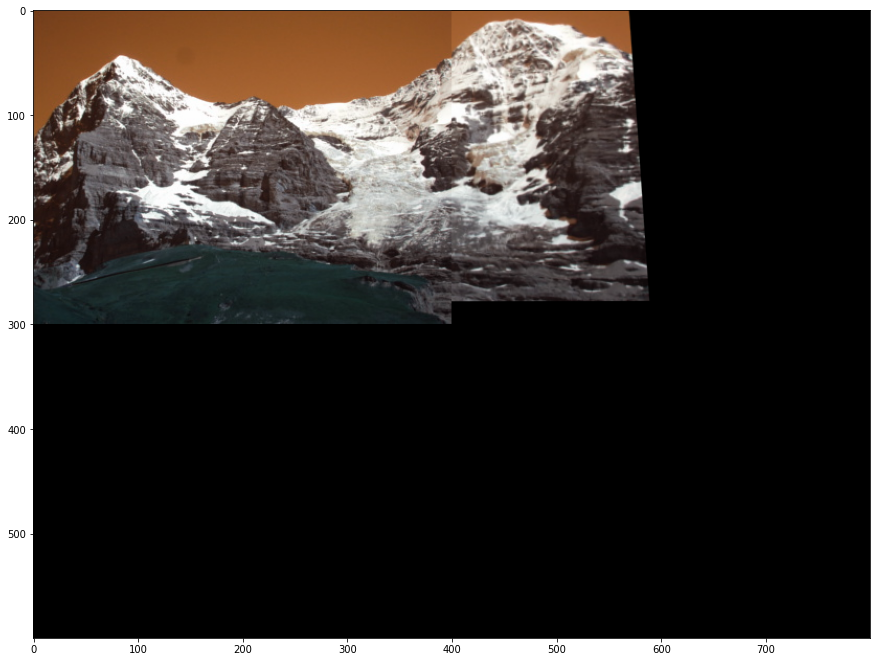

In [20]:
pts1, pts2, good_matches, matched_pts1, matched_pts2 = get_matching_points(img1, img2, ratio_thresh=0.7)

homography1, _ = cv2.findHomography(matched_pts2, matched_pts1, cv2.RANSAC, 4)

result = cv2.warpPerspective(img2, homography1, (img1.shape[1] * 2, img1.shape[0] * 2))
result[:img1.shape[0], :img1.shape[1]] = img1
plt.imshow(result)

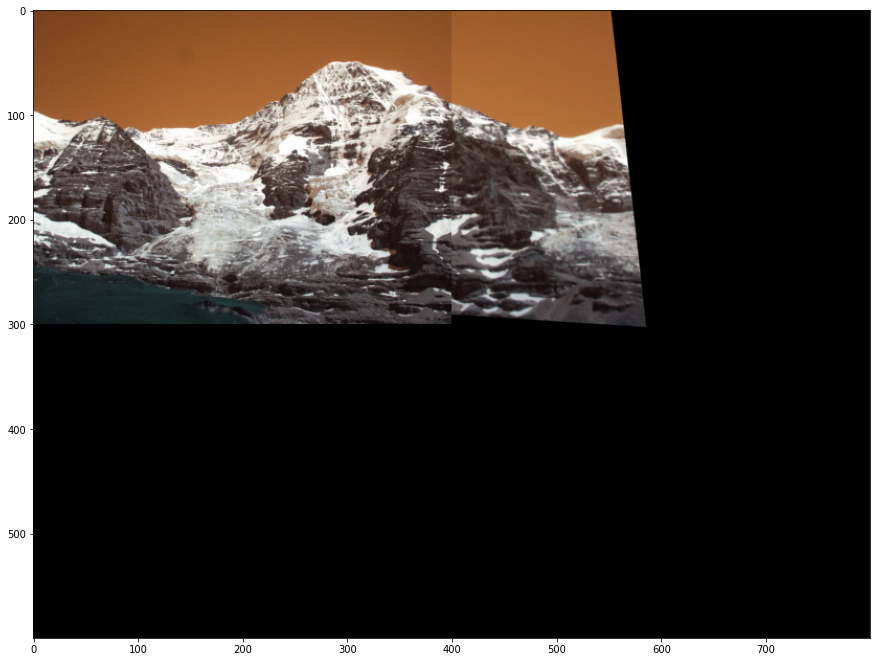

In [21]:
pts1, pts2, good_matches, matched_pts1, matched_pts2 = get_matching_points(img2, img3, ratio_thresh=0.7)

homography2, _ = cv2.findHomography(matched_pts2, matched_pts1, cv2.RANSAC, 4)

result2 = cv2.warpPerspective(img3, homography2, (img2.shape[1] * 2, img2.shape[0] * 2))
result2[:img2.shape[0], :img2.shape[1]] = img2
plt.imshow(result2)

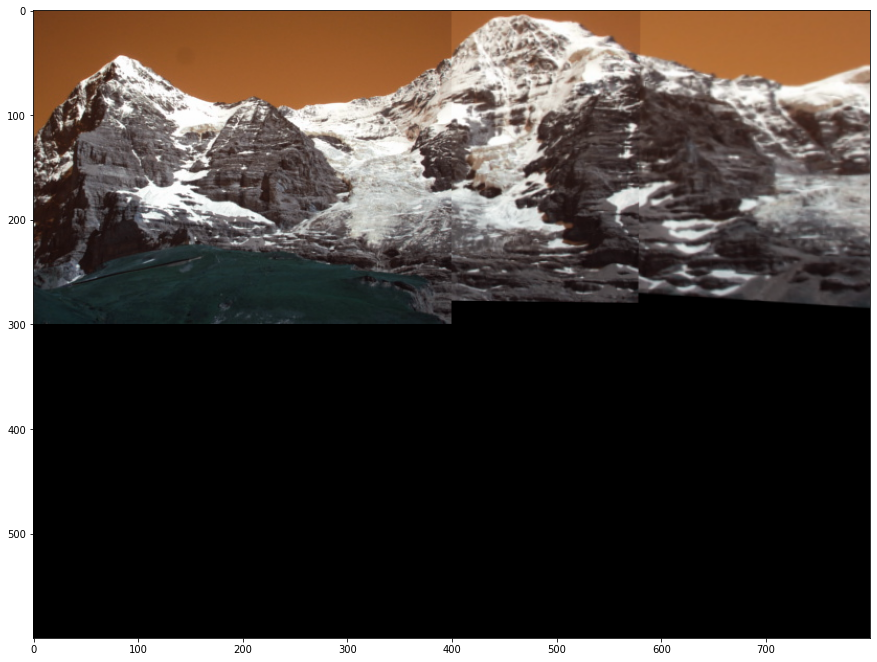

In [22]:
pts1, pts2, good_matches, matched_pts1, matched_pts2 = get_matching_points(img1, result2, ratio_thresh=0.7)

homography3, _ = cv2.findHomography(matched_pts2, matched_pts1, cv2.RANSAC, 4)

result3 = cv2.warpPerspective(result2, homography3, (img1.shape[1] * 2, img1.shape[0] * 2))
result3[:img1.shape[0], :img1.shape[1]] = img1
plt.imshow(result3)